2023-01-09 13:16:38.407851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/fkirsch/miniconda3/envs/tensor/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-09 13:16:42.019753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-0

Epoch 1/10
938/938 [==============================] - 88s 91ms/step - loss: 0.5224 - accuracy: 0.0000e+00 - val_loss: 0.5644 - val_accuracy: 0.0000e+00
Epoch 2/10
938/938 [==============================] - 76s 81ms/step - loss: 0.5595 - accuracy: 0.0000e+00 - val_loss: 0.5639 - val_accuracy: 0.0000e+00
Epoch 3/10
938/938 [==============================] - 89s 95ms/step - loss: 0.5615 - accuracy: 0.0000e+00 - val_loss: 0.5706 - val_accuracy: 0.0000e+00
Epoch 4/10
938/938 [==============================] - 58s 61ms/step - loss: 0.5620 - accuracy: 0.0000e+00 - val_loss: 0.5766 - val_accuracy: 0.0000e+00
Epoch 5/10
938/938 [==============================] - 97s 103ms/step - loss: 0.5624 - accuracy: 0.0000e+00 - val_loss: 0.5695 - val_accuracy: 0.0000e+00
Epoch 6/10
938/938 [==============================] - 93s 99ms/step - loss: 0.5627 - accuracy: 0.0000e+00 - val_loss: 0.5642 - val_accuracy: 0.0000e+00
Epoch 7/10
938/938 [==============================] - 102s 107ms/step - loss: 0.5628 - 

INFO:tensorflow:Assets written to: saved_model/run-1/assets


INFO:tensorflow:Assets written to: saved_model/run-1/assets


INFO:tensorflow:Assets written to: saved_encoder/run-1/assets


INFO:tensorflow:Assets written to: saved_encoder/run-1/assets


INFO:tensorflow:Assets written to: saved_decoder/run-1/assets


INFO:tensorflow:Assets written to: saved_decoder/run-1/assets
2023-01-09 13:52:49.605709: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


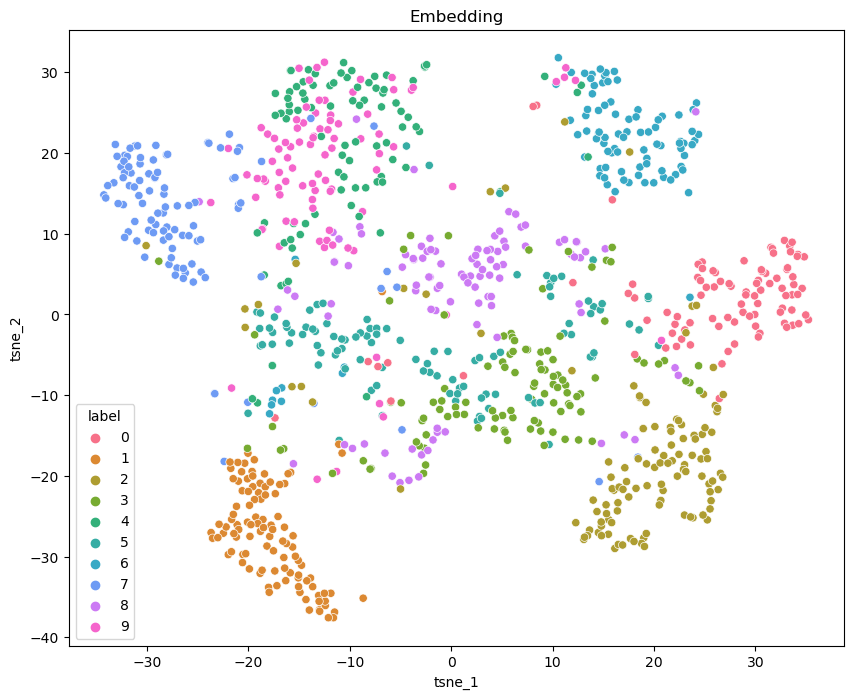

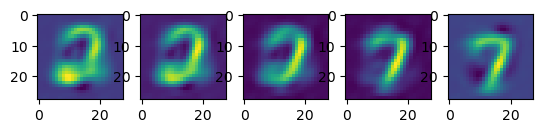

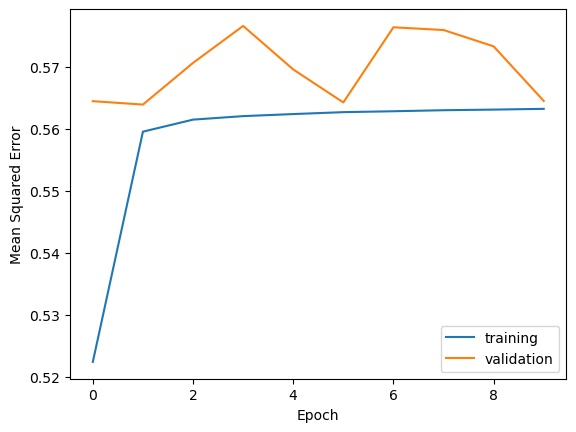

In [1]:
import get_data
from model import MyCNN, MyAutoencoder, MyDecoder
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import seaborn as sns


config = "run-1"
epochs = 10 # around 10
batch_size = 64
noise_std = 0.2
embedding = 10

optimizer = tf.optimizers.Adam(learning_rate=0.001)
loss = tf.losses.MeanSquaredError()

# get and prepare data and model

(training_data, o_val_data ) , ds_info = get_data.load_data(False) # True
#training_data = training_data.take(10) # 
training_data = get_data.data_preprocess(training_data, batch_size = batch_size,noisy = noise_std)
val_data = get_data.data_preprocess(o_val_data, batch_size = batch_size, noisy = noise_std)

encoder = MyCNN(optimizer,embedding,filter_start = 24, regularizer=tf.keras.regularizers.L2(0.001))
decoder = MyDecoder(24)

model = MyAutoencoder(encoder,decoder)

# compile and fit

model.compile(optimizer = optimizer, loss=loss)

logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{config}")

history = model.fit(training_data, validation_data = val_data, epochs=epochs, batch_size=batch_size, callbacks=[logging_callback])

model.save(f"saved_model/{config}")
encoder.save(f"saved_encoder/{config}")
decoder.save(f"saved_decoder/{config}")

# latent space analysis

test_samples = get_data.data_preprocess(o_val_data, batch_size = 1000, noisy = noise_std, targets = True)
for sample in test_samples:
    n,o,t = sample
    sample_embedding = encoder(n) # put noisy images in encoder to get the embeddings
    break

sample_embedding_reduced = TSNE(n_components=2).fit_transform(sample_embedding)

os.makedirs(f"Plots/", exist_ok = True)

# Plot the result of our TSNE with the label color coded
result_df = pd.DataFrame({'tsne_1': sample_embedding_reduced[:,0], 'tsne_2': sample_embedding_reduced[:,1], 'label': t[:1000]})

plt.figure(figsize=(10,8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=result_df, palette = sns.color_palette("husl", 10))
plt.title("Embedding")
plt.savefig(f"Plots/{config}_embedding.png")
plt.show()


# Interpolation

how_many = 5
embedding1 = sample_embedding[0]
embedding2 = sample_embedding[100]
interpolation_embeddings = tf.linspace(embedding1,embedding2,how_many,axis=0)
interpolation_results = decoder(interpolation_embeddings)

f, axes = plt.subplots(1,how_many)
for i in range(how_many):
    axes[i].imshow(interpolation_results[i])
    # the titels are too long, only works if you make the plot full screen
    #axes[i].set_title(np.around(interpolation_embeddings[i].numpy(),decimals=2))
plt.savefig(f"Plots/{config}_interpolation.png")
plt.show()

# plot the training results

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(labels=["training","validation"])
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.savefig(f"Plots/{config}.png")
plt.show()

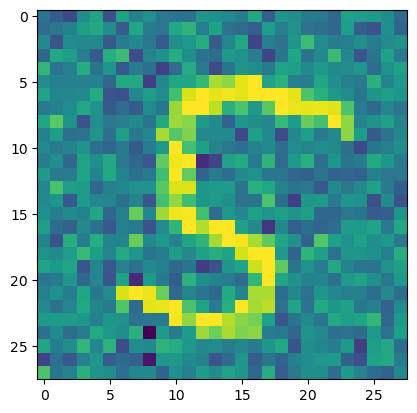

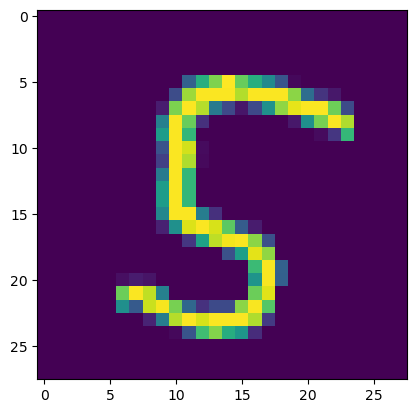

In [2]:
noisy, original = next(iter((training_data.take(1))))

# Display the noisy image
plt.imshow(noisy[0])
plt.show()

# # Display the original image
plt.imshow(original[0])
plt.show()